# EC306: Time Series Econometrics Assignment

# Loading Data

In [170]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA

####################################
##### INITIAL PRE-PROCESSING #####
####################################
DIRECTORY = "D:/Academics/Year 3/EC306 Time Series Econometrics/Assignment"

# loading dataset
data = pd.read_excel(f"{DIRECTORY}/AssignmentQDATA.xlsx")
# re-formatting date variables
data['Date'] = pd.to_datetime(data['Date'], format = "%Y-%m-%d")
data['Date'] = data['Date'].dt.to_period('Q')

# setting date as the index
data.set_index('Date', inplace=True)
data = data.asfreq('Q')

#####################################
####### SERIES EVALUATION ##########
####################################

class SeriesEvaluation:
    """
    This class takes in a time-series and contains
    many auxiliary functions to compute ADF test 
    and plotting functions
    """
    def __init__(self, series: pd.Series, model: str, dropna = False) -> None:
        if dropna:
            series = series.dropna()
        self.series = series
        self.model = model

    def adf_test(self) -> None:
        print(f"Results of Dickey-Fuller Test for {self.series.name}:")
        dftest = adfuller(self.series, autolag="AIC", regression = self.model)
        self.adf_output = pd.Series(dftest[0:4], index=["Test Statistic", "p-value",
                                                 "# Lags Used", "Number of Observations Used"])
        for key, value in dftest[4].items():
            self.adf_output["Critical Value (%s)" % key] = value
        print(self.adf_output)

    def plotting(self) -> None:
        fig, axd = plt.subplot_mosaic([['series', 'series'],
                               ['sacf', 'spacf']],
                              figsize=(10, 5), 
                              layout="constrained")
        try:
            datetime_index = self.series.index.to_timestamp()
        except:
            datetime_index = self.series.index
            
        start_period = min(self.series.index)
        end_period = max(self.series.index)
        yearly_ticks_periods = [pd.Period(f'{year}Q1') for year in range(start_period.year, end_period.year + 1, 5)]
        yearly_ticks = [period.to_timestamp() for period in yearly_ticks_periods]
        
        # plotting series
        axd['series'].plot(datetime_index, self.series)
        axd['series'].set_xlabel("years")
        axd['series'].set_xlim(start_period, end_period)
        axd['series'].set_xticks(yearly_ticks)
        axd['series'].set_xticklabels([f"{period}" for period in yearly_ticks_periods], rotation=0)
        axd['series'].set_ylabel(f"{self.series.name}")
        
        # plotting SACF
        plot_acf(self.series, ax = axd['sacf'], lags = 40)
        axd['sacf'].set_xlabel("lags")
        axd['sacf'].set_ylabel("SACF")
        
        # plotting SPACF
        plot_pacf(self.series, ax = axd['spacf'], lags = 40)
        axd['spacf'].set_xlabel("lags")
        axd['spacf'].set_ylabel("SPACF")
        fig.suptitle(f'{self.series.name} ({start_period} - {end_period})')
    

Results of Dickey-Fuller Test for GDPC1_65:
Test Statistic                  -1.967771
p-value                          0.618874
# Lags Used                      2.000000
Number of Observations Used    181.000000
Critical Value (1%)             -4.009677
Critical Value (5%)             -3.435030
Critical Value (10%)            -3.141459
dtype: float64


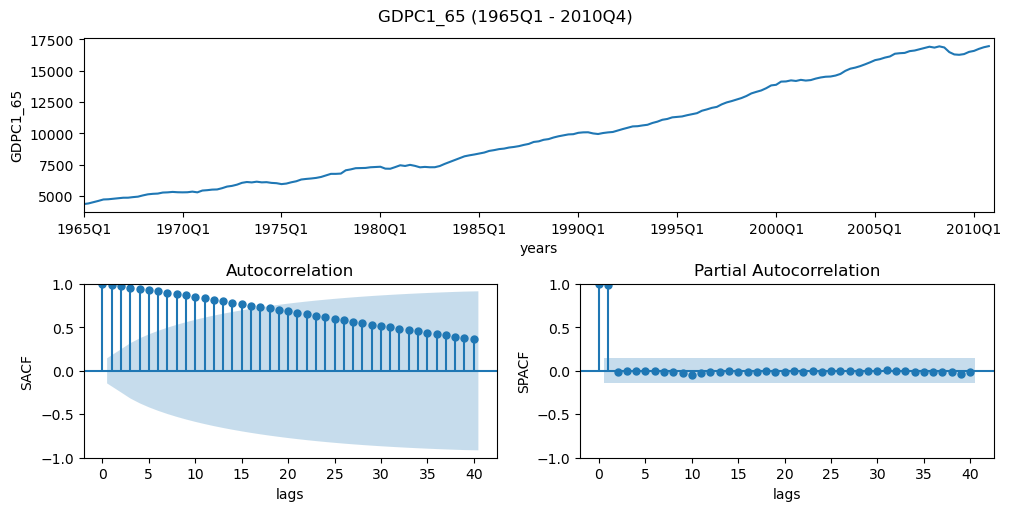

In [171]:
####################################
######## CODE FOR FIGURE 1 ########
####################################
gdp = SeriesEvaluation(series = data['GDPC1_65']['1965Q1':'2010Q4'], 
                      model = "ct")
gdp.adf_test()
gdp.plotting()

The above figure suggests at least an $I(1)$ process as the ACF presents persistent autocorrelation and there is 1 significant partial autocorrelation. Conducting an ADF test should confirm the hypothesis. 

Results of Dickey-Fuller Test for GDPC1_65:
Test Statistic                -6.034209e+00
p-value                        1.394582e-07
# Lags Used                    1.000000e+00
Number of Observations Used    1.810000e+02
Critical Value (1%)           -3.467005e+00
Critical Value (5%)           -2.877644e+00
Critical Value (10%)          -2.575355e+00
dtype: float64


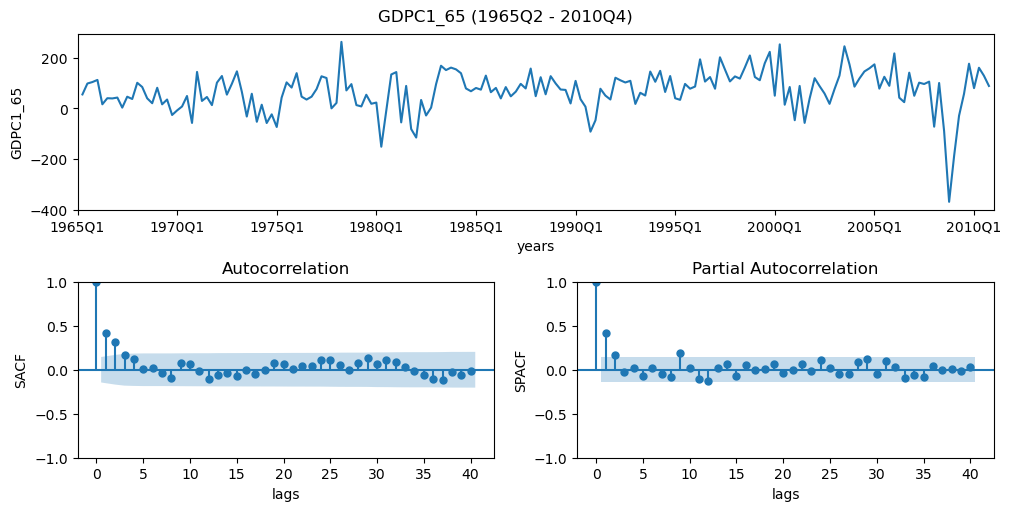

In [172]:
####################################
########  CODE FOR FIGURE 2 ########
####################################

# taking the first difference of real GDP per capita
dgdp = SeriesEvaluation(series = data['GDPC1_65']['1965Q1':'2010Q4'].diff(), 
                      model = "c", dropna=True)
dgdp.adf_test()
dgdp.plotting()

From the above result, we can conclude that real GDP per capita is at least $I(1)$ as we do not reject the null hypothesis that the series is non-stationary. Next, we difference the series to study it's behaviour


The differenced real GDP per capita presents an ARMA(2, 2) structure with two significant lags in the SPACFs and SACFS, with the series often returning to its mean. The following test would confirm whether $\Delta GDP_{pc}$ is $I(0)$ or not.

The ADF test concludes that $GDP_{pc}$ is an $I(1)$ series. The series is log-transformed to see it's structure

In [173]:
####################################
##### MODELS AR(1), ARMA(1, 1) #####
####################################

# first-differenced log-transforming real GDP per capita
data['dlgdp'] = np.log(data['GDPC1_65']).diff()
data.dropna(inplace=True)
train = data.loc[:"2010Q4", 'dlgdp']
test = data.loc["2011Q1":"2019Q4", 'dlgdp']

# defining the ARIMA model
model_1 = ARIMA(endog = train, order = (1, 0, 1)).fit()

# defining the AR models
model_3 = ARIMA(endog = train, order = (2, 0, 0)).fit()

# formatting the results in a table
results = pd.DataFrame({
    'model': ['AR(2)', 'ARMA(1, 1)'],
    'log-liklihood':[model_3.llf, model_1.llf], 
    'AIC': [model_3.aic,  model_1.aic], 
    'BIC':[model_3.bic,  model_1.bic],
    'HQIC':[model_3.hqic,  model_1.hqic],
    '# observations': [model_3.nobs,  model_1.nobs]
})

# printing the results as a table
print(results.T.to_latex(float_format="%.3f", header = False, label = "fig:tab_1", 
                         caption = "Summary of models", column_format = "cccc"))
results

\begin{table}
\caption{Summary of models}
\label{fig:tab_1}
\begin{tabular}{cccc}
\toprule
\midrule
model & AR(2) & ARMA(1, 1) \\
log-liklihood & 627.042 & 626.588 \\
AIC & -1246.084 & -1245.176 \\
BIC & -1233.247 & -1232.338 \\
HQIC & -1240.881 & -1239.972 \\
# observations & 183 & 183 \\
\bottomrule
\end{tabular}
\end{table}



,model,log-liklihood,AIC,BIC,HQIC,# observations
0,AR(2),627.042248,-1246.084496,-1233.246551,-1240.880646,183
1,"ARMA(1, 1)",626.587879,-1245.175758,-1232.337813,-1239.971908,183


C:\Users\sbc13\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sbc13\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sbc13\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR(2)- 1 step evaluation
RMSFE: 0.00423, MAE: 0.00339
AR(2)- 4 step evaluation
RMSFE: 0.0041, MAE: 0.00322
ARMA(1, 1)- 1 step evaluation
RMSFE: 0.00422, MAE: 0.00338
ARMA(1, 1)- 4 step evaluation
RMSFE: 0.00408, MAE: 0.0032


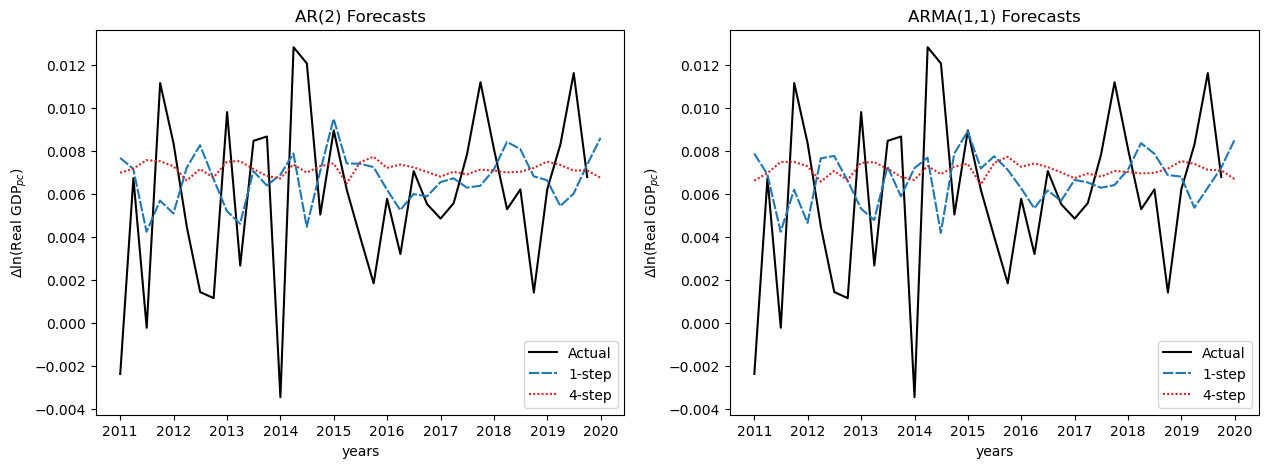

In [174]:
#################################
########### 1(D) ###############
################################

# creating functions for evaluation
class ForecastEvaluation:
    def __init__(self, actual, forecasts):
        self.actual = actual
        self.forecasts = forecasts
        self.combined = pd.DataFrame({'forecast': self.forecasts, 'actual': self.actual}).dropna()
        
    def rmsfe(self):
        result = np.sqrt(np.mean((self.combined['actual'] - self.combined['forecast'])**2))
        return result

    def mae(self):
        result = np.mean(np.abs(self.combined['actual'] - self.combined['forecast']))
        return result
        
    def result_table(self):
        print(f"RMSFE: {round(self.rmsfe(), 5)}, MAE: {round(self.mae(), 5)}")


# creating a function for getting rolling forecast
def rolling_forecast(train_index, end_index, order, step, data):
    
    train_index = data.index.get_loc(train_index)
    end_index = data.index.get_loc(end_index)

    # setting the train data and test data
    train = data.iloc[:train_index - step]
    test = data.iloc[train_index - step + 1 :end_index+1]
    # Initialize storage for 4-step-ahead predictions
    predictions = pd.DataFrame(index=test.index, columns=['forecast', "upper_conf", "lower_conf"])

    for i in range(len(test)-step+1):  # Ensure we stop where a h-step forecast is possible
        # Fit ARIMA model on the current train set
        model = ARIMA(endog=train, order=order).fit()
    
        # Forecast 4 steps ahead
        forecasts = model.get_forecast(steps=step)
        
        # Store the 4th step-ahead forecast along with the confidence intervals
        predictions.loc[test.index[i+step-1]] = [forecasts.predicted_mean.iloc[step-1], 
                                                  forecasts.conf_int().iloc[step-1, 0],
                                                 forecasts.conf_int().iloc[step-1, 1]]
    
        # Append the actual observed value to training set with correct index 
        train = pd.concat([train, pd.Series(test.iloc[i], index=[test.index[i]])])

    # predictions.dropna(inplace=True)
    return predictions

dlgdp = np.log(data['GDPC1_65']).diff().dropna()
train_index = "2010Q4"
end_index = "2019Q4"

# getting the forecasts for the AR(2) model
ar2_1step = rolling_forecast(train_index, end_index, order = (2, 0, 0), step = 1, data = dlgdp)
ar2_4step = rolling_forecast(train_index, end_index, order = (2, 0, 0), step = 4, data = dlgdp)

# getting the forecasts for the ARMA(1, 1) model
arma11_1step = rolling_forecast(train_index, end_index, order = (1, 0, 1), step = 1, data = dlgdp)
arma11_4step = rolling_forecast(train_index, end_index, order = (1, 0, 1), step = 4, data = dlgdp)


# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

#  AR(2)
axes[0].plot(test.index.to_timestamp(),  test, label='Actual', color='black')
axes[0].plot(ar2_1step.index, ar2_1step['forecast'], label='1-step', color='tab:blue', linestyle=(0, (5, 1)))
axes[0].plot(ar2_4step.index, ar2_4step['forecast'], label='4-step', color='tab:red', linestyle=(0, (1, 1)))
axes[0].set_title('AR(2) Forecasts')
axes[0].set_ylabel('$\Delta$ln(Real GDP$_{pc}$)')
axes[0].set_xlabel('years')
axes[0].legend()

# ARMA(1, 1)
axes[1].plot(test.index.to_timestamp(), test, label='Actual', color='black')
axes[1].plot(arma11_1step.index, arma11_1step['forecast'], label='1-step', color='tab:blue', linestyle=(0, (5, 1)))
axes[1].plot(arma11_4step.index, arma11_4step['forecast'], label='4-step', color='tab:red', linestyle=(0, (1, 1)))
axes[1].set_title('ARMA(1,1) Forecasts')
axes[1].set_ylabel('$\Delta$ln(Real GDP$_{pc}$)')
axes[1].set_xlabel('years')
axes[1].legend()

#plt.savefig("YOUR_DIRECTORY/figure_3.png")


# printing evaluations
print("AR(2)- 1 step evaluation")
ForecastEvaluation(actual = dlgdp, forecasts = ar2_1step['forecast']).result_table()
print("AR(2)- 4 step evaluation")
ForecastEvaluation(actual = dlgdp, forecasts = ar2_4step['forecast']).result_table()

print("ARMA(1, 1)- 1 step evaluation")
ForecastEvaluation(actual = dlgdp, forecasts = arma11_1step['forecast']).result_table()
print("ARMA(1, 1)- 4 step evaluation")
ForecastEvaluation(actual = dlgdp, forecasts = arma11_4step['forecast']).result_table()

Direct-step evaluation
RMSFE: 0.00417, MAE: 0.00332


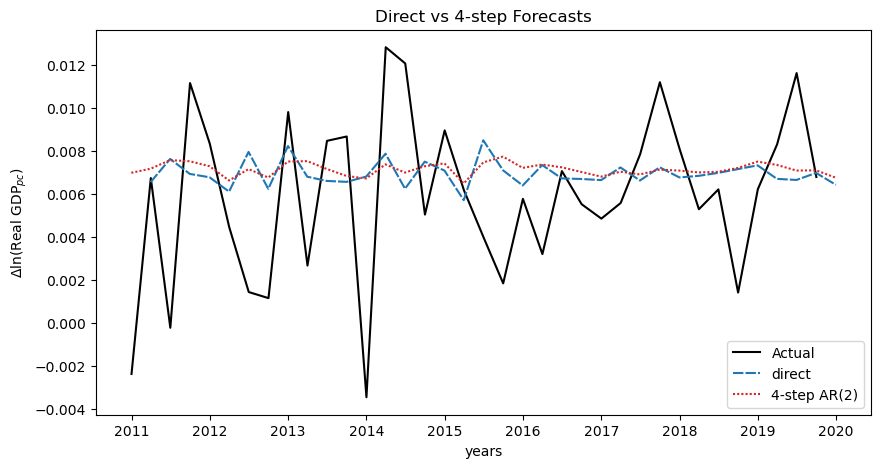

In [188]:
#################################
########### 1(E) ################
#################################

# creating the dataset:
q1_e = pd.DataFrame({
    "dlgdp": dlgdp, 
    "L4.dlgdp": dlgdp.shift(4), 
    "L5.dlgdp": dlgdp.shift(5) 
})
q1_e.dropna(inplace=True)

# creating a function for getting direct forecast
def direct_forecast(train_index, end_index, data):
    step = 1
    train_index = data.index.get_loc(train_index)
    end_index = data.index.get_loc(end_index)
    
    # setting the train data and test data
    train = data.iloc[:train_index - step].copy()
    test = data.iloc[train_index - step + 1:end_index+1].copy()
    
    # Initialize storage for 1-step-ahead predictions
    predictions = pd.DataFrame(index=test.index, columns=['forecast'])
    
    for i in range(len(test)-step+1):  # Ensure we stop where a h-step forecast is possible
        # separate the train into Y and X
        Y_train = train['dlgdp']
        X_train = train[['L4.dlgdp', 'L5.dlgdp']]
        X_train = sm.add_constant(X_train)
        
        # Fit OLS model
        model = sm.OLS(Y_train, X_train).fit()
        
        # define X_test & forecast 4-periods ahead
        X_test = np.asarray([1, test.iloc[i+step-1, 1], test.iloc[i+step-1, 2]])
        forecast = model.predict(exog=X_test.reshape(1, -1))
        # Store the forecast
        predictions.loc[test.index[i+step-1]] = forecast[0]
        # Append the actual observed value to training set with correct index
        train = pd.concat([train, test.iloc[i:i+1]])
    
    return predictions

# Call the function
direct_forecasts = direct_forecast(train_index="2011Q1", end_index="2019Q4", data=q1_e)

# Plot the results
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(test.index.to_timestamp(),  test, label='Actual', color='black')
axes.plot(direct_forecasts.index, direct_forecasts['forecast'], label='direct', color='tab:blue', linestyle=(0, (5, 1)))
axes.plot(ar2_4step.index, ar2_4step['forecast'], label='4-step AR(2)', color='tab:red', linestyle=(0, (1, 1)))
axes.set_title('Direct vs 4-step Forecasts')
axes.set_ylabel('$\Delta$ln(Real GDP$_{pc}$)')
axes.set_xlabel('years')
axes.legend()
plt.savefig("D:/Academics/Year 3/EC306 Time Series Econometrics/Assignment/plots/q1e_direct_forecast.png")

# Conducting evaluation
print("Direct-step evaluation")
ForecastEvaluation(actual = dlgdp, forecasts = direct_forecasts['forecast']).result_table()

# Question 2

Results of Dickey-Fuller Test for BAA:
Test Statistic                -1.028243e+01
p-value                        5.917342e-16
# Lags Used                    0.000000e+00
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.998680e+00
Critical Value (5%)           -3.429753e+00
Critical Value (10%)          -3.138368e+00
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                    BAA   No. Observations:                  231
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -113.532
Date:                Wed, 09 Apr 2025   AIC                            233.063
Time:                        08:37:34   BIC                            243.391
Sample:                    06-30-1965   HQIC                           237.229
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
      

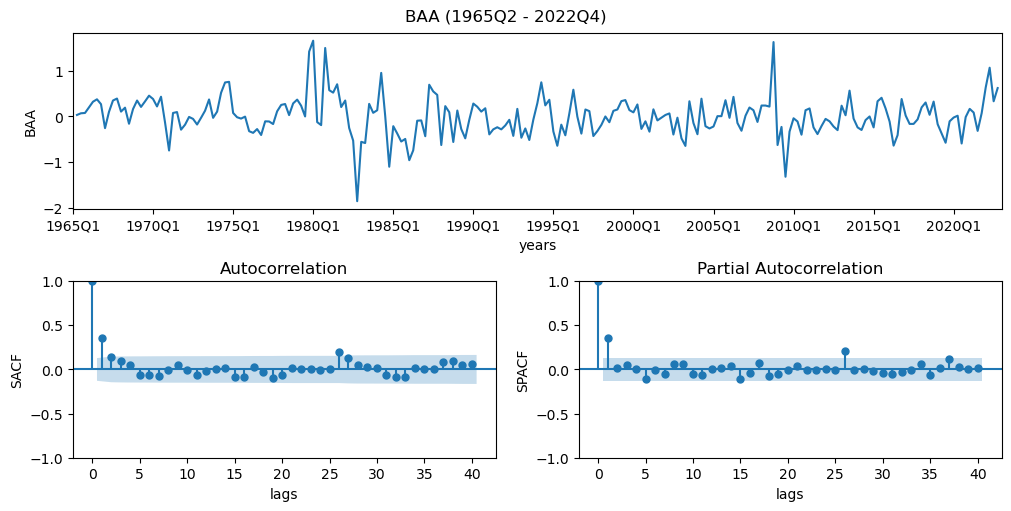

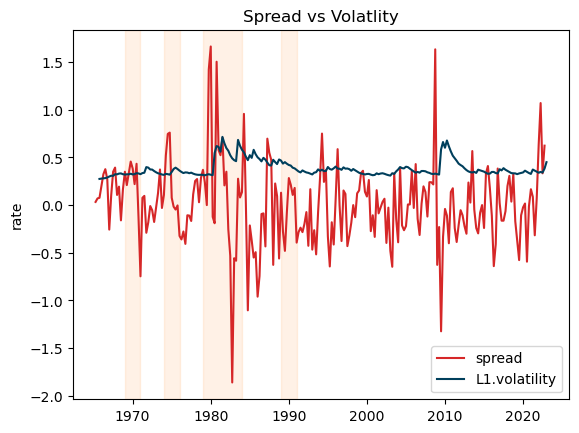

In [126]:
spread = data['baa'].diff(1)
spread.dropna(inplace = True)
spread.name = "BAA"
spread_eval = SeriesEvaluation(series=spread, model = "ct")
spread_eval.plotting()
spread_eval.adf_test()

# ARIMA & GARCH modelling
spread_arima = ARIMA(endog = spread, order = (1, 0, 0)).fit()
print(spread_arima.summary())


arch_test=het_arch(spread_arima.resid, nlags = 4) 
print(f"ARCH Effects Test: \nTest Statistic: {arch_test[0]}\nP-Value: {arch_test[1]}")


garch_model = arch_model(spread_arima.resid, vol='GARCH', p=1, o=0, q=1).fit(disp="off")
print(garch_model.summary())

# extracting conditional volatility
vol = garch_model.conditional_volatility


SeriesEvaluation(vol, "c").adf_test()

# generating constant for regression and training dataset
OLS_data = pd.DataFrame({"dlrinv": np.log(data['RINV']).diff(1), 
                         "cons": [1 for j in range(len(vol))],
                        "L1.vol": vol.shift(), 
                        "spread": spread},
                 index = vol.index)
OLS_data.dropna(inplace = True)

# running OLS
model = sm.OLS(OLS_data['dlrinv'], OLS_data[["L1.vol", "cons"]]).fit()
print(model.summary())
SeriesEvaluation(model.resid, "c").adf_test()

plt.figure()
# plotting the spread vs volatility
plt.plot(spread.index.to_timestamp(), spread.values, color = "tab:red", label = 'spread')
plt.plot(OLS_data["L1.vol"], color = "#003f5c", label = 'L1.volatility')
plt.axvspan(xmin="1979-01-01", xmax = "1984-01-01", color = "tab:orange", alpha = 0.1)
plt.axvspan(xmin="1974-01-01", xmax = "1976-01-01", color = "tab:orange", alpha = 0.1)
plt.axvspan(xmin="1969-01-01", xmax = "1971-01-01", color = "tab:orange", alpha = 0.1)
plt.axvspan(xmin="1989-01-01", xmax = "1991-01-01", color = "tab:orange", alpha = 0.1)
plt.ylabel("rate")
plt.title("Spread vs Volatlity")
plt.legend()

Results of Dickey-Fuller Test for spread:
Test Statistic                  -2.891499
p-value                          0.046345
# Lags Used                      8.000000
Number of Observations Used    506.000000
Critical Value (1%)             -3.443340
Critical Value (5%)             -2.867269
Critical Value (10%)            -2.569821
dtype: float64
Results of Dickey-Fuller Test for FEDFUNDS:
Test Statistic                  -3.171149
p-value                          0.021717
# Lags Used                     16.000000
Number of Observations Used    498.000000
Critical Value (1%)             -3.443549
Critical Value (5%)             -2.867361
Critical Value (10%)            -2.569870
dtype: float64
                               SARIMAX Results                                
Dep. Variable:               FEDFUNDS   No. Observations:                  515
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -407.893
Date:                Wed, 09 Apr 2025   AIC                

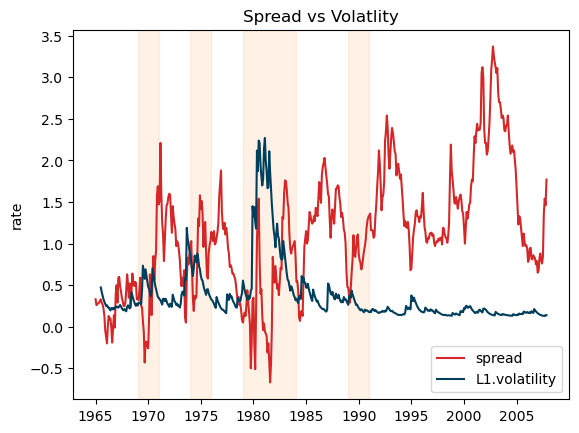

In [130]:
import pandas as pd
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from arch import arch_model


# reading the dataset
monthly_data = pd.read_excel("D:/Academics/Year 3/EC306 Time Series Econometrics/Assignment/InterestRates.xlsx")
monthly_data.set_index('DATE', inplace=True)
monthly_data = monthly_data.asfreq("MS")

# extracting the delta fed funds rate and spread
dffr = monthly_data['FEDFUNDS'][0:monthly_data.index.get_loc("2007-12-01")]
dffr.dropna(inplace = True)
spread = monthly_data['AAA'][min(dffr.index):max(dffr.index)] - monthly_data['GS5'][min(dffr.index):max(dffr.index)]
spread.name = "spread"
# conducting ADF test
SeriesEvaluation(spread, model = "c").adf_test()
SeriesEvaluation(dffr, model = "c").adf_test()

# ARIMA & GARCH modelling
ffr_arima = ARIMA(endog = ffr, order = (2, 0, 1)).fit()
print(ffr_arima.summary())

arch_test =het_arch(ffr_arima.resid, nlags = 4) 
print(f"ARCH Effects Test: \nTest Statistic: {arch_test[0]}\nP-Value: {arch_test[1]}")


garch_model = arch_model(ffr_arima.resid, vol='GARCH', p=1, o=1, q=1).fit(disp="off")
print(garch_model.summary())

# extracting conditional volatility
vol = garch_model.conditional_volatility


# generating constant for regression and training dataset
OLS_data = pd.DataFrame({"vol": vol, 
                         "cons": [1 for j in range(len(vol))],
                        "L1.vol": vol.shift(), 
                        "L6.vol": vol.shift(6), 
                        "spread": spread,
                         "inf_rate": np.log(monthly_data['CPIAUCSL']).diff(2)},
                 index = vol.index)
OLS_data.dropna(inplace = True)

# running OLS
model = sm.OLS(OLS_data['spread'], OLS_data[["L1.vol", "cons", "inf_rate"]]).fit()
print(model.summary())


SeriesEvaluation(vol, model = "c").adf_test()
SeriesEvaluation(model.resid, model = "c").adf_test()

# plotting the spread vs volatility
plt.plot(spread, color = "tab:red", label = 'spread')
plt.plot(OLS_data["L1.vol"], color = "#003f5c", label = 'L1.volatility')
plt.axvspan(xmin="1979-01-01", xmax = "1984-01-01", color = "tab:orange", alpha = 0.1)
plt.axvspan(xmin="1974-01-01", xmax = "1976-01-01", color = "tab:orange", alpha = 0.1)
plt.axvspan(xmin="1969-01-01", xmax = "1971-01-01", color = "tab:orange", alpha = 0.1)
plt.axvspan(xmin="1989-01-01", xmax = "1991-01-01", color = "tab:orange", alpha = 0.1)
plt.ylabel("rate")
plt.title("Spread vs Volatlity")
plt.legend()


Results of Dickey-Fuller Test for FEDFUNDS:
Test Statistic                  -2.748675
p-value                          0.065987
# Lags Used                     17.000000
Number of Observations Used    690.000000
Critical Value (1%)             -3.439863
Critical Value (5%)             -2.865738
Critical Value (10%)            -2.569005
dtype: float64
Results of Dickey-Fuller Test for FEDFUNDS:
Test Statistic                  -5.377953
p-value                          0.000004
# Lags Used                     16.000000
Number of Observations Used    690.000000
Critical Value (1%)             -3.439863
Critical Value (5%)             -2.865738
Critical Value (10%)            -2.569005
dtype: float64
Results of Dickey-Fuller Test for BAA - AAA:
Test Statistic                  -4.330247
p-value                          0.000394
# Lags Used                      7.000000
Number of Observations Used    699.000000
Critical Value (1%)             -3.439740
Critical Value (5%)             -2.8656

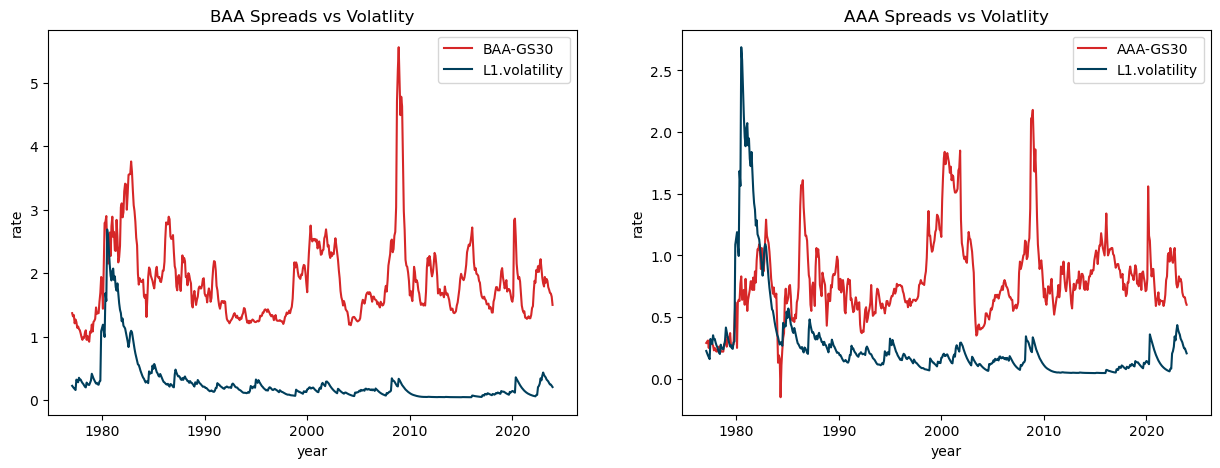

In [224]:
import pandas as pd
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from arch import arch_model
from stargazer.stargazer import Stargazer

# reading the dataset
monthly_data = pd.read_excel("D:/Academics/Year 3/EC306 Time Series Econometrics/Assignment/InterestRates.xlsx")
monthly_data.set_index('DATE', inplace=True)
monthly_data = monthly_data.asfreq("MS")

# extracting the delta fed funds rate and spreads
dffr = monthly_data['FEDFUNDS'].diff()
dffr.dropna(inplace = True)

BAA_AAA = monthly_data['BAA'][min(dffr.index):max(dffr.index)] - monthly_data['AAA'][min(dffr.index):max(dffr.index)]
BAA_AAA.name = "BAA - AAA"

BAA_GS30 = monthly_data['BAA']["1977-02-01":] - monthly_data['GS30']["1977-02-01":]
BAA_GS30.name = "BAA - GS30"



# conducting ADF test
SeriesEvaluation(monthly_data['FEDFUNDS'], model = "c").adf_test()
SeriesEvaluation(dffr, model = "c").adf_test()
SeriesEvaluation(BAA_AAA, model = "c").adf_test()
SeriesEvaluation(BAA_GS30, model = "c").adf_test()
SeriesEvaluation(np.log(monthly_data['CPIAUCSL']).diff(2), model = "c", dropna = True).adf_test()

# ARIMA modelling
ffr_arima = ARIMA(endog = dffr, order = (2, 0, 1)).fit()
print(ffr_arima.summary())
# conducting ARCH Effects test
arch_test=het_arch(ffr_arima.resid, nlags = 6) 
print(f"ARCH Effects Test: \nTest Statistic: {arch_test[0]}\nP-Value: {arch_test[1]}")
# GARCH modelling
garch_model = arch_model(ffr_arima.resid, vol='GARCH', p=1, o=1, q=1).fit(disp="off")
print(garch_model.summary())


# generating OLS dataset
OLS_data = pd.DataFrame({"vol": garch_model.conditional_volatility, 
                         "cons": [1 for j in range(len(garch_model.conditional_volatility))],
                         "L1.vol": garch_model.conditional_volatility.shift(), 
                         "BAA - AAA": BAA_AAA,
                         "BAA - GS30": BAA_GS30,
                         "inf_rate": np.log(monthly_data['CPIAUCSL']).diff(2)},
                 index = garch_model.conditional_volatility.index)
OLS_data.dropna(inplace = True)

# running OLS
model_1 = sm.OLS(OLS_data['BAA - AAA'], OLS_data[["cons", "L1.vol", "inf_rate"]]).fit()
model_2 = sm.OLS(OLS_data['BAA - GS30'], OLS_data[["cons", "L1.vol", "inf_rate"]]).fit()


# checking for spurious correlation
SeriesEvaluation(model_1.resid, model = "c").adf_test()
SeriesEvaluation(model_2.resid, model = "c").adf_test()
SeriesEvaluation(garch_model.conditional_volatility, model = "c").adf_test()

# printing output into latex using Stargazer
stargazer = Stargazer([model_1, model_2])
stargazer.custom_columns(['BAA - AAA', 'BAA - GS30'], [1, 1])
stargazer.rename_covariates({'cons': 'constant', 'L1.vol': 'L1 rate volatility', 'inf_rate': 'inflation rate'})
stargazer.title("GARCH in mean with different spreads")
stargazer.show_degrees_of_freedom(False)
print(stargazer.render_latex())

# plotting output
#plt.save("D:/Academics/Year 3/EC306 Time Series Econometrics/Assignment/plots/q1_plot.")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(BAA_GS30.index, BAA_GS30, color = "tab:red", label = 'BAA-GS30')
axes[0].plot(OLS_data["L1.vol"], color = "#003f5c", label = 'L1.volatility')
axes[0].set_ylabel("rate")
axes[0].set_xlabel("year")
axes[0].set_title("BAA Spreads vs Volatlity")
axes[0].legend()

axes[1].plot(AAA_GS30.index, AAA_GS30, color = "tab:red", label = 'AAA-GS30')
axes[1].plot(OLS_data["L1.vol"], color = "#003f5c", label = 'L1.volatility')
axes[1].set_ylabel("rate")
axes[1].set_xlabel("year")
axes[1].set_title("AAA Spreads vs Volatlity")
axes[1].legend()

#fig.savefig("D:/Academics/Year 3/EC306 Time Series Econometrics/Assignment/plots/q2_plot.png")


### Question 3


Since real investment (seasonally adjusted) presents an exponential growth, the series is log differenced for stationarity

In [296]:
SeriesEvaluation(data['RINV'], model = "ct").adf_test()

Results of Dickey-Fuller Test for gs10:
Test Statistic                  -3.052737
p-value                          0.117928
# Lags Used                      3.000000
Number of Observations Used    217.000000
Critical Value (1%)             -4.001106
Critical Value (5%)             -3.430919
Critical Value (10%)            -3.139051
dtype: float64


There appears to be a structural break at 1985. Post 1985Q4 the series is trend-stationary quite easily.

In [297]:
SeriesEvaluation(series = data['ffr'], model = "ct").adf_test()

Results of Dickey-Fuller Test for ffr:
Test Statistic                  -2.915475
p-value                          0.157264
# Lags Used                      7.000000
Number of Observations Used    213.000000
Critical Value (1%)             -4.001913
Critical Value (5%)             -3.431306
Critical Value (10%)            -3.139278
dtype: float64


Although federal funds rates shows stationarity at the 10% level, since the test is low-powered, we are better of differencing them.

In [298]:
SeriesEvaluation(series = data['GDP1_65'], model = "ct").adf_test()

Results of Dickey-Fuller Test for baa:
Test Statistic                  -2.818114
p-value                          0.190371
# Lags Used                      1.000000
Number of Observations Used    219.000000
Critical Value (1%)             -4.000714
Critical Value (5%)             -3.430730
Critical Value (10%)            -3.138940
dtype: float64


Requires differencing.

In [299]:
# differencing/log differencing series to induce stationarity
data['dlgdp'] = np.log(data['GDPC1_65']).diff()
data['dlrinv'] = np.log(data['RINV']).diff()
data['dffr'] = data['ffr'].diff()
data.dropna(inplace= True)

In [301]:
# Now we conduct the same stationarity tests again:
SeriesEvaluation(data['dlgdp'], model = "c").adf_test()
SeriesEvaluation(data['dlrinv'], model = "c").adf_test()
SeriesEvaluation(data['dffr'], model = "c").adf_test()

Results of Dickey-Fuller Test for dlgdp:
Test Statistic                -1.477031e+01
p-value                        2.328018e-27
# Lags Used                    0.000000e+00
Number of Observations Used    2.190000e+02
Critical Value (1%)           -3.460567e+00
Critical Value (5%)           -2.874830e+00
Critical Value (10%)          -2.573853e+00
dtype: float64
Results of Dickey-Fuller Test for dlrinv:
Test Statistic                -7.010329e+00
p-value                        6.948532e-10
# Lags Used                    1.000000e+00
Number of Observations Used    2.180000e+02
Critical Value (1%)           -3.460708e+00
Critical Value (5%)           -2.874891e+00
Critical Value (10%)          -2.573886e+00
dtype: float64
Results of Dickey-Fuller Test for dffr:
Test Statistic                -6.525260e+00
p-value                        1.018388e-08
# Lags Used                    6.000000e+00
Number of Observations Used    2.130000e+02
Critical Value (1%)           -3.461429e+00
Critical Va

All the series are stationary.Next I conduct Granger-Causality tests to see whether a variable helps forecast GDP growth rates.

In [319]:
from statsmodels.tsa.stattools import grangercausalitytests

# defining function to create granger-causality matrix
def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test'):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

result = granger_causation_matrix(data[['dlgdp', 'dlrinv', 'dffr']], ['dlgdp', 'dlrinv', 'dffr'], p = 4)
print(result.to_latex())


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=217, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=0.0001  , p=0.9916  , df_denom=217, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=215, df_num=2
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=0.3877  , p=0.6791  , df_denom=215, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=213, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=0.3140  , p=0.8153  , df_denom=213, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=-0.0000 , p=1.0000  

In [329]:
from statsmodels.tsa.api import VAR

# splitting the dataset into train and test
train = data["1965Q4":"2010Q4"][['dlgdp', 'dlrinv',  'dffr']]
test = data["2010Q4":"2019Q4"][['dlgdp', 'dlrinv', 'dffr']]

# Fit the VAR model
model = VAR(train)
results = model.fit(maxlags=2, ic='aic')  # using AIC to choose optimal lag length

# Summary of the regression equation for dlgdp
print(results.summary())

# Conducting portmanteau test for serial correlation
q_test = results.test_whiteness(nlags=4)
print(q_test)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Apr, 2025
Time:                     09:37:52
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -19.8574
Nobs:                     170.000    HQIC:                  -20.2520
Log likelihood:           815.448    FPE:                1.22406e-09
AIC:                     -20.5215    Det(Omega_mle):     9.95831e-10
--------------------------------------------------------------------
Results for equation dlgdp
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.005199         0.000906            5.735           0.000
L1.dlgdp         -0.151657         0.108466           -1.398           0.162
L1.dlrinv         0.164686         0.040978            4.019           0.000

VAR(4)- 1 step evaluation
           Value
MSE     0.000022
RMSE    0.004646
MAE     0.003489
MAPE  186.325066
VAR(4)- 4 step evaluation
           Value
MSE     0.000018
RMSE    0.004286
MAE     0.003252
MAPE  195.556001


{'MSE': 1.8372575033187096e-05,
 'RMSE': 0.004286324186664734,
 'MAE': 0.003252080707269761,
 'MAPE': 195.55600122827624}

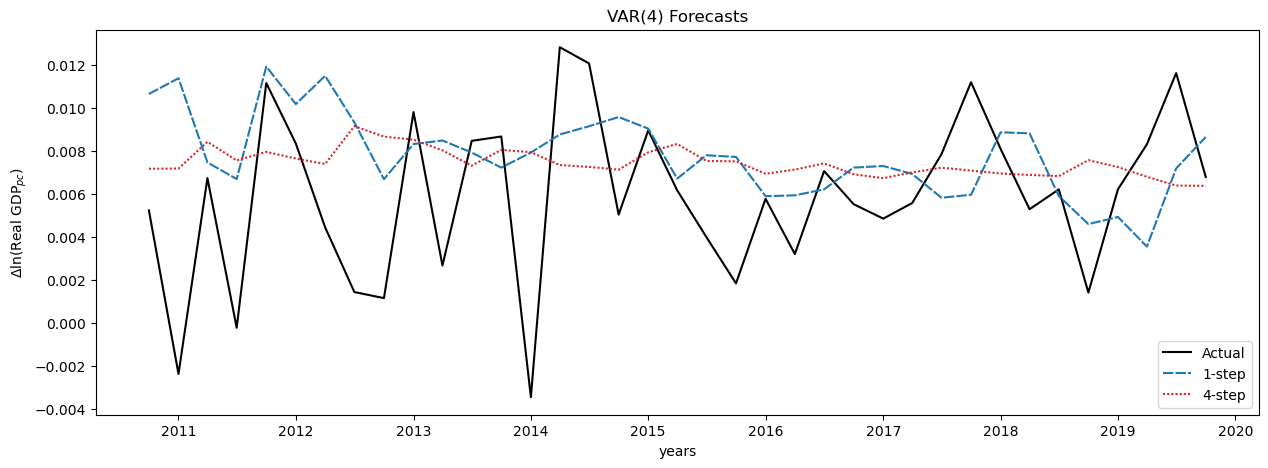

In [331]:
######################################
# ROLLING VAR FORECASTS for comparison
######################################

def rolling_forecast_var(train_index, end_index, step, data):
    train_index = data.index.get_loc(train_index)
    end_index = data.index.get_loc(end_index)

    # Set initial train and test data
    train = data.iloc[:train_index - step]
    test = data.iloc[train_index - step + 1 : end_index + 1]

    # Prepare storage for forecasts
    predictions = pd.DataFrame(index=test.index, columns=['forecast', "upper_conf", "lower_conf"])

    for i in range(len(test) - step + 1):  # Loop through rolling windows
        # Fit VAR model
        model = VAR(train)
        results = model.fit(maxlags=3, ic='aic')

        # Forecast
        forecast_mean, lower, upper = results.forecast_interval(train.values[-3:], steps=step)

        # Get index of forecasted date (step-ahead)
        forecast_date = test.index[i + step - 1]

        # Get column index for dlgdp
        dlgdp_idx = data.columns.get_loc('dlgdp')

        # Store step-ahead forecast
        predictions.loc[forecast_date] = [
            forecast_mean[step - 1][dlgdp_idx],
            upper[step - 1][dlgdp_idx],
            lower[step - 1][dlgdp_idx]
        ]

        # Add the current observation to the train set
        train = pd.concat([train, test.iloc[[i]]])

    predictions.dropna(inplace = True)
    return predictions

q3 = data[['dlgdp', 'dlrinv', 'dffr']]
var2_1step = rolling_forecast_var(train_index="2010Q4", end_index = "2019Q4", step = 1, data = q2)
var2_4step = rolling_forecast_var(train_index="2010Q4", end_index = "2019Q4", step = 4, data = q2)

# Plot the results
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

#  VAR(2)
series = data['2010Q4':'2019Q4']['dlgdp']
axes.plot(series.index.to_timestamp(), series,label='Actual', color='black')
axes.plot(var2_1step.index.to_timestamp(), var2_1step['forecast'], label='1-step', color='tab:blue', linestyle=(0, (5, 1)))
axes.plot(var2_4step.index.to_timestamp(), var2_4step['forecast'], label='4-step', color='tab:red', linestyle=(0, (1, 1)))
axes.set_title('VAR(4) Forecasts')
axes.set_ylabel('$\Delta$ln(Real GDP$_{pc}$)')
axes.set_xlabel('years')
axes.legend()

print("VAR(4)- 1 step evaluation")
ForecastEvaluation(actual = series, forecasts = var2_1step['forecast']).result_table()
print("VAR(4)- 4 step evaluation")
ForecastEvaluation(actual = series, forecasts = var2_4step['forecast']).result_table()


# Question 4:

To include the higher-frequency data, there are two methods available:
1. Bridging equation
2. MIDAS

## Bridging equations
Bridging equation is a 2-step process whereby we do the following:
1. Augment the higher-frequency data by taking their fitted values.
2. Then, we aggregate the fitted values according to a specific rule.
3. We model this data in the lower-frequency space.


C:\Users\sbc13\AppData\Local\Temp\ipykernel_3320\65841323.py:98: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_months = pd.date_range(start=last_month_dt + pd.DateOffset(months=1),
C:\Users\sbc13\AppData\Local\Temp\ipykernel_3320\65841323.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  complete_monthly = pd.concat([
C:\Users\sbc13\AppData\Local\Temp\ipykernel_3320\65841323.py:15: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  return monthly_data.resample('Q').mean()
C:\Users\sbc13\AppData\Local\Temp\ipykernel_3320\65841323.py:123: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future vers


Bridging Equation - 1 step evaluation
           Value
MSE     0.000021
RMSE    0.004600
MAE     0.003469
MAPE  189.997465

Bridging Equation - 4 step evaluation
           Value
MSE     0.000022
RMSE    0.004722
MAE     0.003614
MAPE  228.296981


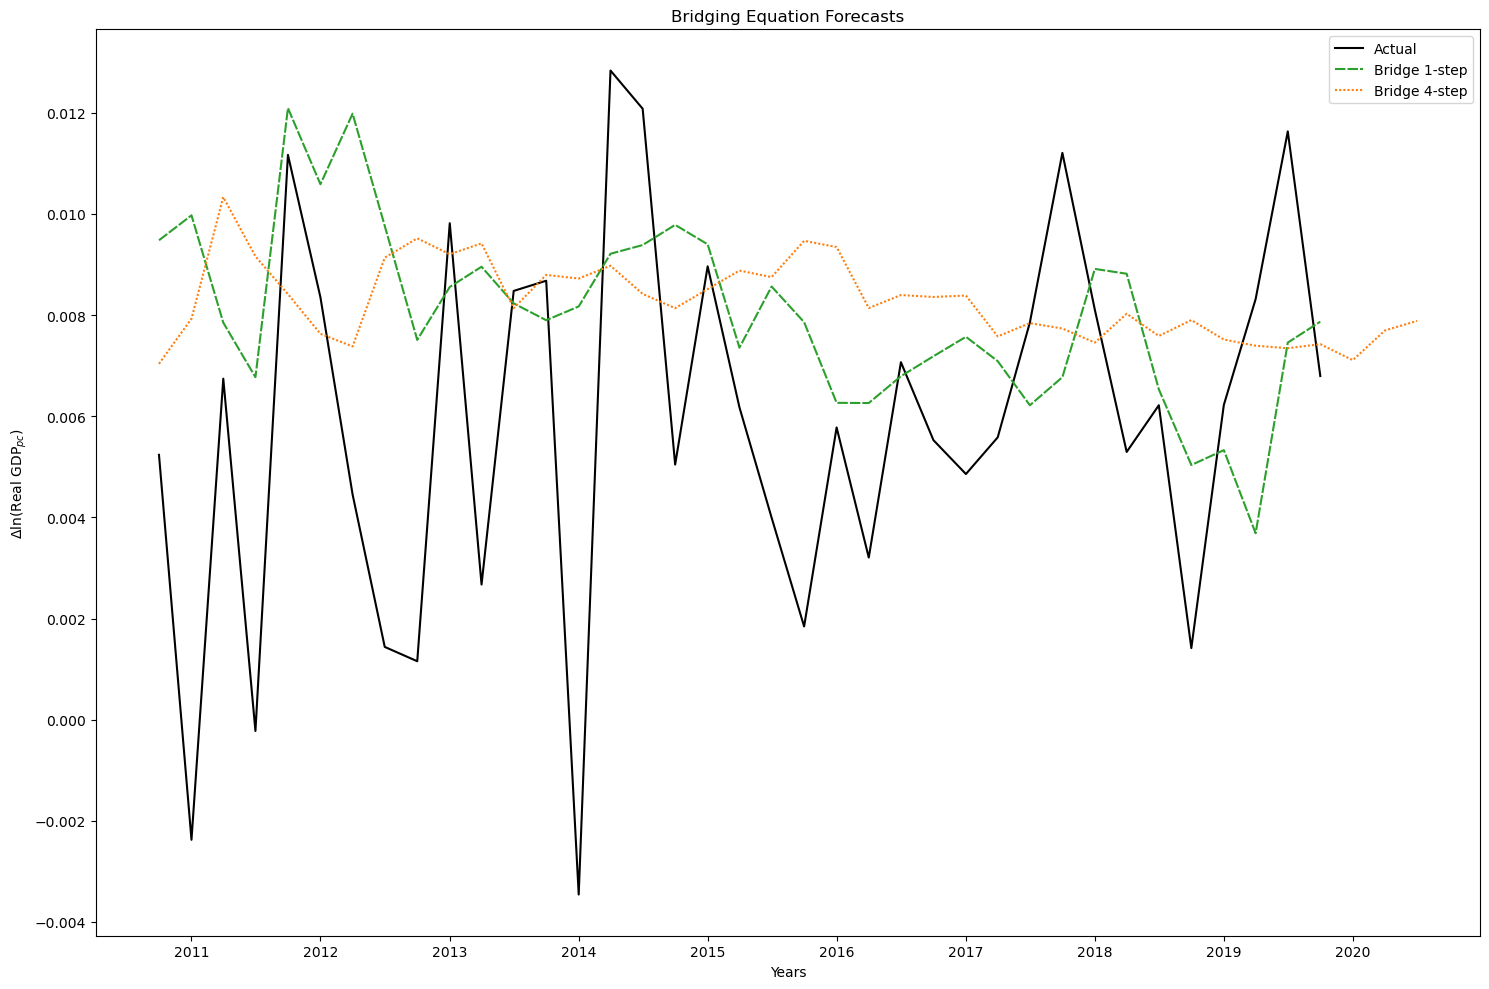

In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import MonthEnd

# Function to aggregate monthly data to quarterly
def monthly_to_quarterly(monthly_data, aggregation='mean'):
    if aggregation == 'mean':
        return monthly_data.resample('Q').mean()
    elif aggregation == 'sum':
        return monthly_data.resample('Q').sum()
    elif aggregation == 'last':
        return monthly_data.resample('Q').last()

# Function to forecast monthly inflation using ARIMA(1,0,3)
def forecast_monthly_inflation(inflation_data, steps=3):
    model = ARIMA(inflation_data, order=(1, 0, 3))
    results = model.fit()
    forecast = results.forecast(steps=steps)
    return forecast

# Function to implement bridging equations for quarterly forecasts
def bridging_equation_forecast(quarterly_data, monthly_data, start_date, end_date, h_step, aggregation='mean'):
    # Make a copy of the data to avoid modifying the original
    quarterly_data = quarterly_data.copy()
    
    # Ensure the quarterly data has a PeriodIndex with quarterly frequency
    if not isinstance(quarterly_data.index, pd.PeriodIndex):
        quarterly_data.index = pd.PeriodIndex(quarterly_data.index, freq='Q')
    
    # Ensure monthly data has a DatetimeIndex with monthly frequency
    if isinstance(monthly_data, pd.Series):
        monthly_df = monthly_data.to_frame(name='inf_rate')
    else:
        monthly_df = monthly_data.copy()
    
    # Convert monthly index to DatetimeIndex if it's not already
    if not isinstance(monthly_df.index, pd.DatetimeIndex):
        monthly_df.index = pd.DatetimeIndex(monthly_df.index)
    
    # Make sure the index is sorted
    monthly_df = monthly_df.sort_index()
    
    # Convert string dates to period indices if needed
    if isinstance(start_date, str):
        start_date = pd.Period(start_date, freq='Q')
    if isinstance(end_date, str):
        end_date = pd.Period(end_date, freq='Q')
    
    # Get dataframe indices
    start_idx = quarterly_data.index.get_loc(start_date)
    end_idx = quarterly_data.index.get_loc(end_date)
    
    # Initialize results dataframe
    predictions = pd.DataFrame(index=quarterly_data.loc[start_date:end_date].index, 
                              columns=['forecast', 'upper_conf', 'lower_conf'])
    
    # Start rolling window forecasts
    for i in range(start_idx - h_step + 1, end_idx + 1):
        # Current quarter for forecast
        current_quarter = quarterly_data.index[i]
        target_quarter = quarterly_data.index[i + h_step - 1]
        
        # Prepare training data up to current quarter
        train_quarterly = quarterly_data.iloc[:i]
        
        # Find the last month of the current quarter as datetime
        last_month_dt = current_quarter.to_timestamp(how='E')
        
        # Get available monthly data up to last_month
        available_monthly = monthly_df[monthly_df.index <= last_month_dt]
        
        # Forecast monthly inflation for future months needed
        forecast_horizon = 3 * h_step  # Number of months to forecast
        
        # Generate monthly forecasts
        monthly_forecasts = forecast_monthly_inflation(available_monthly['inf_rate'], steps=forecast_horizon)
        
        # Create future monthly dates
        future_months = pd.date_range(start=last_month_dt + pd.DateOffset(months=1), 
                                      periods=forecast_horizon, freq='M')
        
        # Combine available and forecasted monthly data
        complete_monthly = pd.concat([
            available_monthly,
            pd.DataFrame(monthly_forecasts, index=future_months, columns=['inf_rate'])
        ])
        
        # Aggregate to quarterly
        quarterly_inf = monthly_to_quarterly(complete_monthly, aggregation=aggregation)
        
        # Convert quarterly_inf index to PeriodIndex to match train_quarterly
        quarterly_inf.index = pd.PeriodIndex(quarterly_inf.index, freq='Q')
        
        # Merge with quarterly training data
        enhanced_quarterly = train_quarterly.copy()
        enhanced_quarterly['inf_rate'] = np.nan  # Initialize column
        
        # Fill in the inflation values for the quarters we have
        for idx in quarterly_inf.index:
            if idx in enhanced_quarterly.index:
                enhanced_quarterly.loc[idx, 'inf_rate'] = quarterly_inf.loc[idx, 'inf_rate']
        
        # Forward fill any missing values (should be minimal)
        enhanced_quarterly.fillna(method='ffill', inplace=True)
        
        # Fit VAR model with enhanced data
        try:
            model = VAR(enhanced_quarterly)
            results = model.fit(maxlags=2, ic='aic')
            
            # Forecast
            forecast_mean, lower, upper = results.forecast_interval(enhanced_quarterly.values[-2:], steps=h_step)
            
            # Store forecast for the target quarter
            dlgdp_idx = enhanced_quarterly.columns.get_loc('dlgdp')
            predictions.loc[target_quarter] = [
                forecast_mean[h_step - 1][dlgdp_idx],
                upper[h_step - 1][dlgdp_idx],
                lower[h_step - 1][dlgdp_idx]
            ]
        except Exception as e:
            print(f"Error for quarter {current_quarter}: {e}")
            continue

    predictions.dropna(inplace=True)
    return predictions


# Main function to run the forecasts
def run_bridging_forecast(data, inf_rate):
    # Ensure data has PeriodIndex
    if not isinstance(data.index, pd.PeriodIndex):
        data.index = pd.PeriodIndex(data.index, freq='Q')
    
    # Ensure inf_rate is a DataFrame with DatetimeIndex
    if isinstance(inf_rate, pd.Series):
        inf_rate_df = inf_rate.to_frame(name='inf_rate')
    else:
        inf_rate_df = inf_rate.copy()
    
    if not isinstance(inf_rate_df.index, pd.DatetimeIndex):
        inf_rate_df.index = pd.DatetimeIndex(inf_rate_df.index)
    
    # Original VAR forecasts (for comparison)
    q4 = data[['dlgdp', 'dlrinv', 'dffr']]
    
    # Bridging equation forecasts
    bridge_1step = bridging_equation_forecast(q4, inf_rate_df, "2010Q4", "2019Q4", 1, aggregation='mean')
    bridge_4step = bridging_equation_forecast(q4, inf_rate_df, "2010Q4", "2019Q4", 4, aggregation='mean')
    
    # Display evaluation metrics
    print("\nBridging Equation - 1 step evaluation")
    bridge1_eval = ForecastEvaluation(actual=series, forecasts=bridge_1step['forecast']).result_table()
    
    print("\nBridging Equation - 4 step evaluation")
    bridge4_eval = ForecastEvaluation(actual=series, forecasts=bridge_4step['forecast']).result_table()
    
    return {
        'bridge_1step': bridge_1step,
        'bridge_4step': bridge_4step,
        'evaluations': {
            'bridge_1step': bridge1_eval,
            'bridge_4step': bridge4_eval
        }
    }
results = run_bridging_forecast(data, inf_rate)